# Ensemble methods for enhancing the resilience of generative AI systems

The example notebook shows how to use PyTorch to implement an ensemble of neural networks for classification, along with visualization of predictions, training, and accuracy calculation

## Importing Libraries

- torch, torch.nn, torch.optim: PyTorch libraries for tensor operations, neural network modules, and optimization algorithms
- torch.utils.data: Tools for handling data loaders and datasets in PyTorch
- sklearn.metrics.accuracy_score: Function to compute the accuracy of classification predictions
- numpy: Library for numerical operations
- matplotlib.pyplot: Library for creating plots and visualizations


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

## Define Simple Neural Network Architecture

- SimpleGenerator Class: Defines a simple feedforward neural network with:

        1. One input layer (fc1) with input_size neurons, connected to a hidden layer (hidden_size neurons)
        
        2. ReLU activation function (relu) applied after the first fully connected layer
        
        3. Output layer (fc2) with output_size neurons, representing the final predictions

In [22]:
# Define a simple neural network architecture
class SimpleGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleGenerator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        return out

## Dataset Generation Function

- Generates synthetic data:

    X: Randomly generated input data of shape (num_samples, input_size)
    
    y: Random integer labels (classes) ranging from 0 to output_size-1, of shape (num_samples,)


In [23]:


# Dataset example
def generate_data(num_samples, input_size, output_size):
    X = torch.randn(num_samples, input_size)
    y = torch.randint(0, output_size, (num_samples,))
    return X, y

## Training Function

- Trains a given model:

    1. train_loader: DataLoader providing batches of training data (inputs and targets)
    
    2. criterion: Loss function (e.g., CrossEntropyLoss) to compute the loss between outputs and targets
    
    3. optimizer: Optimization algorithm (e.g., Adam) to update the model parameters based on the computed gradients
    
    4. epochs: Number of training epochs (passes through the entire dataset)


In [24]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

## Ensemble Model Class

- Represents an ensemble of neural network models:
    1. __init__: Initializes num_models instances of SimpleGenerator as a list (self.models)
    
    2. train_ensemble: Trains each model in self.models using the train_model function
    
    3. predict: Generates predictions by evaluating each model on input x, stacking predictions across models, and aggregating them using mode (majority vote)


In [25]:


# Ensemble model using multiple architectures
class EnsembleGenerator:
    def __init__(self, num_models, input_size, hidden_size, output_size):
        self.models = nn.ModuleList([SimpleGenerator(input_size, hidden_size, output_size) for _ in range(num_models)])

    def train_ensemble(self, train_loader, criterion, optimizer, epochs):
        for model in self.models:
            train_model(model, train_loader, criterion, optimizer, epochs)

    def predict(self, x):
        predictions = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                output = model(x)
                _, predicted = torch.max(output, 1)
                predictions.append(predicted.unsqueeze(0))  # Keep dimension for stacking
        predictions = torch.cat(predictions)
        aggregated_predictions, _ = torch.mode(predictions, dim=0)
        return aggregated_predictions



## Usage

- Demonstrates how to use the EnsembleGenerator class and the SimpleGenerator models to:

    1. Generate synthetic training (X_train, y_train) and test data (X_test, y_test)
    
    2. Train an ensemble of neural networks (ensemble_model) on the training data
    
    3. Predict labels for the test data using the trained ensemble (predicted_labels)
    
 

In [26]:
# Example usage and visualization
input_size = 10
hidden_size = 20
output_size = 5
num_samples = 200
num_models = 3
batch_size = 64
epochs = 10

# Generate synthetic data
X_train, y_train = generate_data(num_samples, input_size, output_size)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize ensemble model
ensemble_model = EnsembleGenerator(num_models, input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.models[0].parameters(), lr=0.001)

# Train ensemble
ensemble_model.train_ensemble(train_loader, criterion, optimizer, epochs)

# Generate test data
X_test, y_test = generate_data(200, input_size, output_size)
test_inputs = torch.tensor(X_test)

# Predict using ensemble model
predicted_labels = ensemble_model.predict(test_inputs)

# Convert tensors to numpy arrays for plotting
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()
predicted_labels_np = predicted_labels.numpy()



/tmp/ipykernel_5324/8858158.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(X_test)


## Visualization

- The scatter plot (plt.scatter) visualizes the synthetic test data points:
    
    1. Colored by their true labels (True Labels) using the viridis colormap
    
    2. Marked with 'x' symbols for predicted labels (Predicted Labels) using the inferno colormap
    
    3. The colorbar (plt.colorbar) shows the color mapping between labels and colors

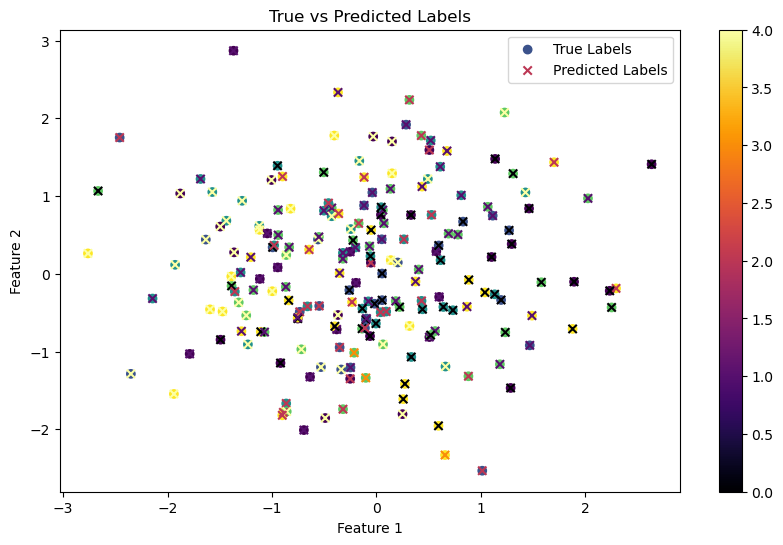

Ensemble Model Accuracy: 0.23


In [30]:
# Plotting predictions
plt.figure(figsize=(10, 6))
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=y_test_np, cmap='viridis', label='True Labels')
plt.scatter(X_test_np[:, 0], X_test_np[:, 1], c=predicted_labels_np, cmap='inferno', marker='x', label='Predicted Labels')
plt.title('True vs Predicted Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.colorbar()
# Save plot in high resolution (300 dpi) as PNG file
plt.savefig('ensemble_predictions.png', dpi=300)

plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, predicted_labels_np)
print(f"Ensemble Model Accuracy: {accuracy}")
